# Headers (load libaries/packages/functions needed)

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
import scipy as sp
import scipy.io as sio
from scipy import stats
from scipy.optimize import curve_fit
import h5py
import numpy as np
import pandas as pd
import time
from IPython.display import Markdown, HTML, display
from pyitlib import discrete_random_variable as drv

pass

In [3]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

In [4]:
#User-defined utility functions
import scipy as sp
def printmd(string):
    display(Markdown(string))
    
def plot_hist(X,binwidth,xlimv,xlabelv,fit):
    barStyles={"width":0.75*binwidth, "linewidth":0, "align":"center"}
    (bins,edges) = np.histogram(X,np.arange(-0.5*binwidth,np.max(X)+1.5*binwidth,binwidth))
    centers = (edges[:-1]+edges[1:])/2
    xdata=centers;ydata=bins/sum(bins)
    pdf = np.zeros((len(bins),2),dtype=float)
    pdf[:,0]=centers
    pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))

    bar(pdf[:,0],pdf[:,1], label='raw', **barStyles)
    if (fit==1):
        param=sp.stats.lognorm.fit(X)
        plt.plot(xdata, sp.stats.lognorm.pdf(xdata, param[0], loc=param[1], scale=param[2]), 'r-',label='lognormal fit')
        legend()
    xlim(-0.5*binwidth,xlimv)
    title(xlabelv); ylabel('pdf')
    
def cal_p_value(p_x,x):
    p_x = sorted(p_x)
    index = np.where(np.array(p_x)<x)[0][-1]+1
    p_value = 1.0-index/(1.0*len(p_x))
    return p_value

# 1 load files

Here we load the .mat files (provided by Tianyou) to python. We merge the datasets from the 2018/10/10 experiment and the 2018/12/01 experiment. We look at the samples collected at different times after triggering (1,2,3,5,7.5,10,20,30,60,120,180 min). For each cell, we extract the following data:

* Par spot number (estimation of MOI)
* cell length
* cI mRNA copy number
* cII mRNA copy number
* cro mRNA copy number

In [5]:
column_names = ['len','moi','ci','cro','cii','time']
df = pd.DataFrame(columns = column_names)

#####################
#filename1 = '2018_single_phage/20181010_infection_dataset_ty.mat'
filename2 = '2018_single_phage/20181201_nasRNA_dataset_ty.mat'

time_after_triggering = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
column_id = [0,1,5,6,11,21,31] #frame; cell_id; len; moi; ci; cro; cii
for filename in [filename2]:
    mat_contents = sio.loadmat(filename)['spotList_w_nasRNA'];
    k = 0;
    for i in range(2,2+len(time_after_triggering)):
        tmp = mat_contents[0][i][:,column_id]
        tmp2=tmp[~np.isnan(tmp).any(axis=1)]
        tmp2=tmp2[tmp2[:,3]>0]
        df_tmp = pd.DataFrame(data=tmp2, 
                              index=[str(time_after_triggering[k])+'_'+str(i) for i in range(1,len(tmp2)+1)], 
                              columns=['frame_id','cell_id','len','moi','ci','cro','cii'])
        df_tmp['time']=np.full((len(tmp2),1),time_after_triggering[k])
        df = pd.concat([df,df_tmp])
        k = k+1;

df['len']=df['len']/(df['len'].median())
df['conc']= df['moi']/df['len']
printmd('**Number of samples at different time points:**')
print(df.groupby(['time'])['moi'].count())

/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



**Number of samples at different time points:**

time
0.5       904
1.0      1199
2.0       726
3.0      1452
5.0      1963
7.5      2653
10.0     1427
20.0     2069
30.0     3326
60.0     1649
120.0    1688
180.0     553
Name: moi, dtype: int64


In [6]:
from scipy.stats import moment
x = np.array([1, 2, 3, 4, 5])
print(np.var(x))
moment(x, moment=3)
#moment([1, 2, 3, 4, 5], moment=2)

2.0


0.0

In [7]:
df_0 = df
df_0['new_id'] = df_0["time"].astype(str)+ '_' + df_0["frame_id"].astype(str) + '_' + df_0["cell_id"].astype(str)
df_0 = df_0[['time','new_id','len', 'moi','conc','ci','cro','cii']]
df_0.reset_index(drop=True,inplace=True)
#df_0['ci'] = df_0['ci'].round(0).astype(int)
#df_0['cro'] = df_0['cro'].round(0).astype(int)
#df_0['cii'] = df_0['cii'].round(0).astype(int)
df_0['len'] = df_0['len'].round(1)
df_0['conc'] = (2*df_0['conc']).round(0)/2.0
#df_0


#df_1 = df_0.groupby('new_id')
#df_1.apply(lambda x: x.max() - x.min())
#print(df.groupby(['frame_id'])['cell_id'].count())

/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
def f_all(x):
    df = pd.DataFrame(sp.stats.moment(x.ci.astype(int),moment=[2]),index=['ci_var']).T
    df['cii_var'] = sp.stats.moment(x.cii.astype(int),moment=[2])
    df['cro_var'] = sp.stats.moment(x.cro.astype(int),moment=[2])
    df['ci_mean'] = np.mean(x.ci)
    df['cii_mean'] = np.mean(x.cii)
    df['cro_mean'] = np.mean(x.cro)
    df['moi'] = np.mean(x.moi)
    df['len'] = np.mean(x.len)
    df['conc'] = np.mean(x.conc)
    df['time'] = np.mean(x.time)
    return df

g = df_0.groupby('new_id').apply(f_all)

/miniconda3/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Avenir'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


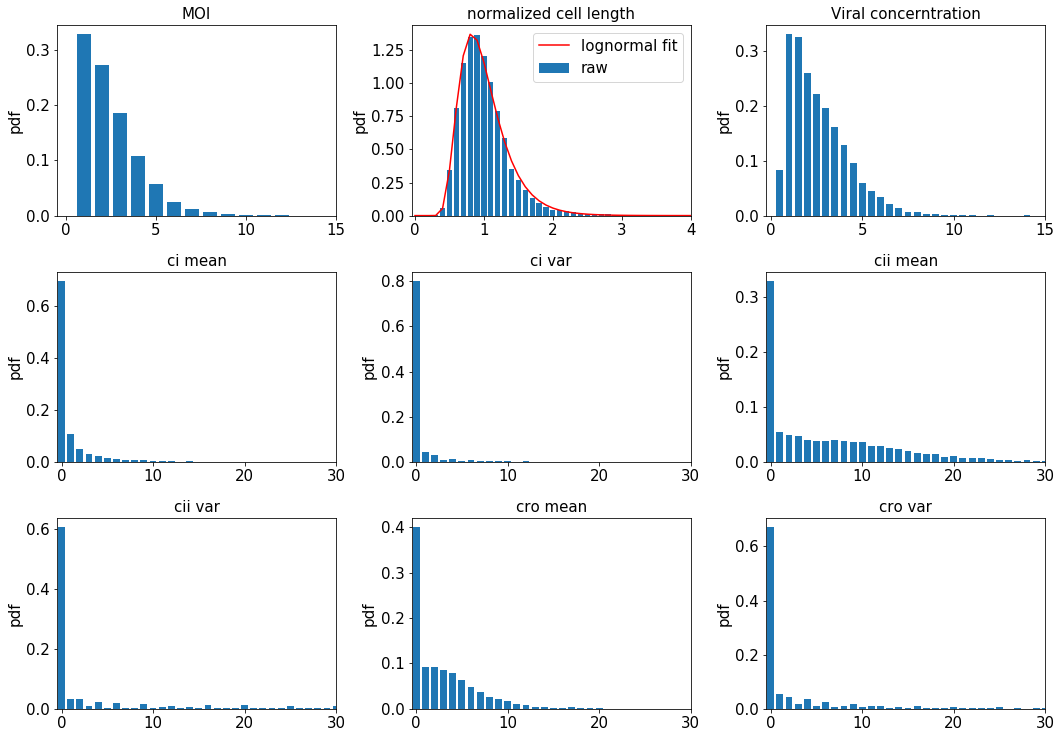

In [9]:
xlabelv_array = ['MOI','normalized cell length','Viral concerntration',
                 'ci mean','ci var', 'cii mean','cii var','cro mean', 'cro var']
fit_array=[0,1,0,0,0,0,0,0,0]
binwidth_array=[1,0.1,0.5,1,1,1,1,1,1]
xlimv_array=[15,4,15,30,30,30,30,30,30,30]
k = 0;
matplotlib.rcParams.update({"figure.figsize": (15,10.5)})
for j in ['moi','len','conc','ci_mean','ci_var','cii_mean','cii_var','cro_mean','cro_var']:
    X = np.array(g[j].to_numpy())
    subplot(3,3,k+1)
    plot_hist(X,binwidth_array[k],xlimv_array[k],xlabelv_array[k],fit_array[k])
    k = k+1;
tight_layout()

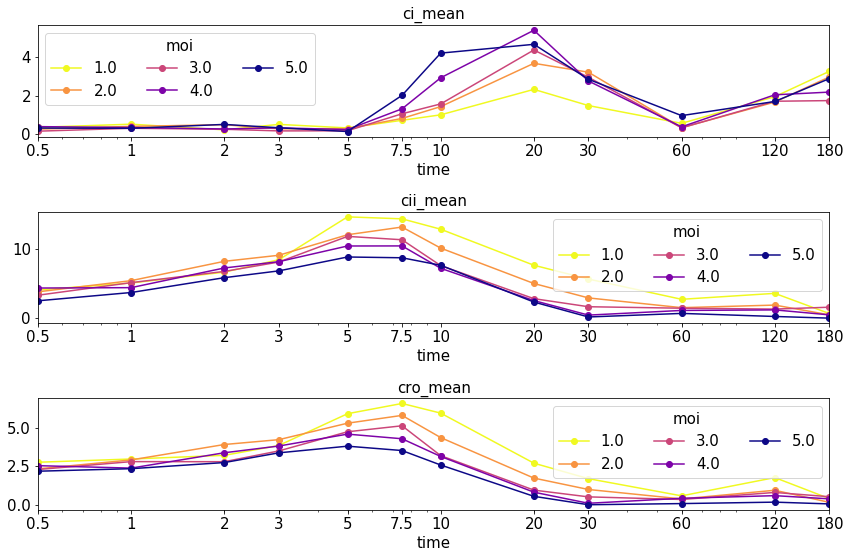

In [10]:
df2 = g
df2 = df2[df2['moi']<=5]
gene = ['ci_mean','cii_mean','cro_mean']
matplotlib.rcParams.update({"figure.figsize": (12,8)})
fig, ax = plt.subplots(3, 1)
for i in range(0,len(gene)):
    ax[i].set_title(gene[i])
    ax[i].set_xscale('log')
    ax[i].set_xticks(time_after_triggering)
    ax[i].set_xticklabels([str(k) for k in time_after_triggering])
    df2.groupby(['time','moi']).mean()[gene[i]].unstack().plot(ax=ax[i],
                                                               cmap='plasma_r',
                                                               linestyle='solid', 
                                                               marker='o')
    if i == 0:
        ax[i].legend(title='moi',loc="upper left",ncol=3)
    else:
        ax[i].legend(title='moi',loc="upper right",ncol=3)
tight_layout()

# 2 Method to estimate mutual information (MI)
### 2.1 theoretial formula

For discrete random variables $X \sim p(x)$, and $Y \sim p(y)$, we have:

entropy: $H(X) = \sum _\chi p(x)\log p(x)$ (Note that $\chi$ denotes the set of all possible realizations of $X$)

joint entropy: $H(X,Y) = \sum _\chi \sum _\gamma p(x,y)\log p(x,y)$

mutual information: $I(X;Y) = H(X) + H(Y) - H(X,Y)$

(p.41-42, Cover & Thomas, Elements of Information Theory, 1991)

### 2.2 the maximum likelihood estimator of mutual information is biased

In reality, we don't know the true distribution of $X$ and $Y$, and we have to estimate them from finite observations (with sample size $N$). The maximum likelihood estimator of entropy (the empirical entropy) is: 

$\tilde{H_N}(X) = \sum _{\{a\}} \frac{N(x=a)}{N} \log \frac{N(x=a)}{N}$, 

where $N(x=a)$ is the time that $a$ appears. 

One can show that the empirical entropy and empirical mutual information is biased. (Paninski, Liam. "Estimation of entropy and mutual information." Neural computation 15.6 (2003): 1191-1253.)

### 2.3 unbiased mutual information estimation (the Miller-Madow estimator)

One can show that, when the number of non-zero bins of p(x), p(y), and p(x,y) (denotated as $m_x$, $m_y$, $m_{xy}$ respectively) is fixed, 

$\tilde{I_N}(X;Y) = I(X;Y) - \frac{1}{N}\cdot \frac{m_{xy}-m_x-m_y-1}{2} + O(\frac{1}{N})$, 

where $I(X;Y)$ is the true mutual information and $\tilde{I_N}(X;Y)$ is the empirical estimator based on $N$ samples. If we omit the higher order terms, $\tilde{I_N}(X;Y)$ is just a linear function of $\frac{1}{N}$, and the $y$ intercept of the function (correponding to an infinite sample size) should be the true $I(X;Y)$. Using this method, as N goes to infinity, the error goes to 0. 

We could therefore:

<font color='red'>1) subset the original dataset with sample size $N_1<N_2<...<N$, and for each $N_i$, calculate $\tilde{I_{N_i}}(X;Y)$;</font>

<font color='red'>2) fit pairs ($\frac{1}{N_i}$, $\tilde{I_{N_i}}(X;Y)$) with a linear function; </font>

<font color='red'>3) extract the $y$ intercept of the fitted function, which is the true mutual information $I(X;Y)$. </font>

(Paninski, Liam. "Estimation of entropy and mutual information." Neural computation 15.6 (2003): 1191-1253.)

### 2.4 normalized mutual information
Normalized mutual information (NMI) is defined as the mutual information between X and Y over the total entropy: $NMI(X;Y) = \frac{I(X;Y)}{H(X,Y)}$. Although this quantity is rarely mentioned in the classic testbook, it could be understood as the information theoretic correspondence of Pearson correlation coefficient. NMI captures the nonlinear dependence between X and Y. Therefore we also calculated NMI for our data, just for reference. 

In [11]:
#calculate empirical mutual information between (X1,X2) and Z
def I_X1_X2_wrt_Z(X1,X2,Z):
    H_X1_X2 = drv.entropy_joint(np.array((X1,X2)), estimator='ML')
    H_X1_X2_Z = drv.entropy_joint(np.array((X1,X2,Z)), estimator='ML')
    H_Z = drv.entropy(Z, estimator='ML')   
    I = H_X1_X2 + H_Z - H_X1_X2_Z    
    return I

#calculate empirical mutual information between (X1,X2,X3) and Z
def I_X1_X2_X3_X4_wrt_Z(X1,X2,X3,X4,Z):
    H_Xn = drv.entropy_joint(np.array((X1,X2,X3,X4)), estimator='ML')
    H_Xn_Z = drv.entropy_joint(np.array((X1,X2,X3,X4,Z)), estimator='ML')
    H_Z = drv.entropy(Z, estimator='ML')
    I = H_Xn + H_Z - H_Xn_Z
    return I

def I_X1_X2_X3_X4_X5_X6_wrt_Z(X1,X2,X3,X4,X5,X6,Z):
    H_Xn = drv.entropy_joint(np.array((X1,X2,X3,X4,X5,X6)), estimator='ML')
    H_Xn_Z = drv.entropy_joint(np.array((X1,X2,X3,X4,X5,X6,Z)), estimator='ML')
    H_Z = drv.entropy(Z, estimator='ML')
    I = H_Xn + H_Z - H_Xn_Z
    return I    

In [19]:
def linear(x,a,b):
    return (a*x+b)

def plot_MI2(xdata,ydata,popt_MI,gene_name,t):
    matplotlib.rcParams.update({"figure.figsize": (5,4)})
    plt.plot(xdata,ydata,'o',label='raw',**plotStyles)
    plt.plot(xdata,linear(xdata,*popt_MI),'r-',linewidth=2,label='fit')
    plt.title('MI='+str(round(popt_MI[1],2)))
    tight_layout()
    plt.savefig('check4phage_1201/MI2_'+gene_name+'_'+str(t)+'.pdf')
    plt.close()
        
def cal_MI_wrt_Z(X1,X2,X3,X4,X5,X6,Z,t,save_figure):
    size = np.array([0.9,0.8,0.7,0.6,0.5])*len(X1);
    size = size.astype(int)
    index = range(0,len(X1))
    xdata = 1.0/size;
    ydata1 = np.array([], dtype=float)
    ydata2 = np.array([], dtype=float)
    ydata3 = np.array([], dtype=float)
    ydata4 = np.array([], dtype=float) 
    ydata5 = np.array([], dtype=float)
    ydata6 = np.array([], dtype=float)
    ydata7 = np.array([], dtype=float)
    N_sample = 500
    for j in size:
        temp_MI1 = np.zeros(N_sample);temp_MI2 = np.zeros(N_sample);temp_MI3 = np.zeros(N_sample)
        temp_MI4 = np.zeros(N_sample);temp_MI5 = np.zeros(N_sample);temp_MI6 = np.zeros(N_sample)
        temp_MI7 = np.zeros(N_sample);
        for N in range(0,N_sample):
            index_2 = np.random.choice(index, j,replace=True);
            X1_ = X1[index_2]; X2_ = X2[index_2]; X3_ = X3[index_2]; 
            X4_ = X4[index_2]; X5_ = X5[index_2]; X6_ = X6[index_2]; 
            Z_ = Z[index_2];
            temp_MI1[N] = I_X1_X2_wrt_Z(X1_, X2_, Z_) #ci
            temp_MI2[N] = I_X1_X2_wrt_Z(X3_, X4_, Z_) #cii
            temp_MI3[N] = I_X1_X2_wrt_Z(X5_, X6_, Z_) #cro
            temp_MI4[N] = I_X1_X2_X3_X4_wrt_Z(X1_, X2_, X3_, X4_, Z_); #ci_cii
            temp_MI5[N] = I_X1_X2_X3_X4_wrt_Z(X1_, X2_, X5_, X6_, Z_); #ci_cro
            temp_MI6[N] = I_X1_X2_X3_X4_wrt_Z(X3_, X4_, X5_, X6_, Z_); #cii_cro
            temp_MI7[N] = I_X1_X2_X3_X4_X5_X6_wrt_Z(X1_, X2_, X3_, X4_, X5_, X6_, Z_) #ci_cii_cro
        ydata1 = np.append(ydata1, np.mean(temp_MI1));
        ydata2 = np.append(ydata2, np.mean(temp_MI2));
        ydata3 = np.append(ydata3, np.mean(temp_MI3));
        ydata4 = np.append(ydata4, np.mean(temp_MI4));
        ydata5 = np.append(ydata5, np.mean(temp_MI5));
        ydata6 = np.append(ydata6, np.mean(temp_MI6));
        ydata7 = np.append(ydata7, np.mean(temp_MI7));
    popt_MI1, pcov_MI1 = curve_fit(linear, xdata, ydata1)
    popt_MI2, pcov_MI2 = curve_fit(linear, xdata, ydata2)
    popt_MI3, pcov_MI3 = curve_fit(linear, xdata, ydata3)
    popt_MI4, pcov_MI4 = curve_fit(linear, xdata, ydata4)
    popt_MI5, pcov_MI5 = curve_fit(linear, xdata, ydata5)
    popt_MI6, pcov_MI6 = curve_fit(linear, xdata, ydata6)
    popt_MI7, pcov_MI7 = curve_fit(linear, xdata, ydata7)
    if (save_figure==1):
        plot_MI2(xdata,ydata1,popt_MI1,'ci',t);
        plot_MI2(xdata,ydata2,popt_MI2,'cii',t);
        plot_MI2(xdata,ydata3,popt_MI3,'cro',t);
        plot_MI2(xdata,ydata4,popt_MI4,'ci_cii',t);
        plot_MI2(xdata,ydata5,popt_MI5,'ci_cro',t);
        plot_MI2(xdata,ydata6,popt_MI6,'cii_cro',t);
        plot_MI2(xdata,ydata7,popt_MI7,'ci_cii_cro',t);
    
    return (popt_MI1[1], popt_MI2[1], popt_MI3[1],popt_MI4[1],popt_MI5[1],popt_MI6[1],popt_MI7[1])
        

# 3 Does cI/cII/cro count MOI?



# 4 When does cI/cII/cro count MOI best? 


In [34]:
df3 = g #df3 = df3[df3['time']<60]
time_after_triggering3 = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]

MI_data1 = np.zeros(len(time_after_triggering3))
MI_data2 = np.zeros(len(time_after_triggering3))
MI_data3 = np.zeros(len(time_after_triggering3))
MI_data4 = np.zeros(len(time_after_triggering3))
MI_data5 = np.zeros(len(time_after_triggering3))
MI_data6 = np.zeros(len(time_after_triggering3))
MI_data7 = np.zeros(len(time_after_triggering3))

for t_i in range(0,len(time_after_triggering3)):   
    df4 = df3[df3['time']==time_after_triggering3[t_i]]
    X1 = np.array(df4['ci_mean'].to_numpy());X1 = np.rint(X1)
    X2 = np.array(df4['ci_var'].to_numpy());X2 = np.rint(X2)
    X3 = np.array(df4['cii_mean'].to_numpy());X3 = np.rint(X3)
    X4 = np.array(df4['cii_var'].to_numpy());X4 = np.rint(X4)
    X5 = np.array(df4['cro_mean'].to_numpy());X5 = np.rint(X5)
    X6 = np.array(df4['cro_var'].to_numpy());X6 = np.rint(X6)
    Z = np.array(df4['moi'].to_numpy());
    (MI_data1[t_i],MI_data2[t_i],MI_data3[t_i],MI_data4[t_i],MI_data5[t_i],MI_data6[t_i],MI_data7[t_i]) = \
    cal_MI_wrt_Z(X1,X2,X3,X4,X5,X6,Z,time_after_triggering3[t_i],1)
np.savetxt('file4phage_1201/ci.csv', MI_data1, delimiter=",")
np.savetxt('file4phage_1201/cii.csv', MI_data2, delimiter=",")
np.savetxt('file4phage_1201/cro.csv', MI_data3, delimiter=",")    
np.savetxt('file4phage_1201/ci_cii.csv', MI_data4, delimiter=",")
np.savetxt('file4phage_1201/ci_cro.csv', MI_data5, delimiter=",")
np.savetxt('file4phage_1201/cii_cro.csv', MI_data6, delimiter=",")
np.savetxt('file4phage_1201/ci_cii_cro.csv', MI_data7, delimiter=",")

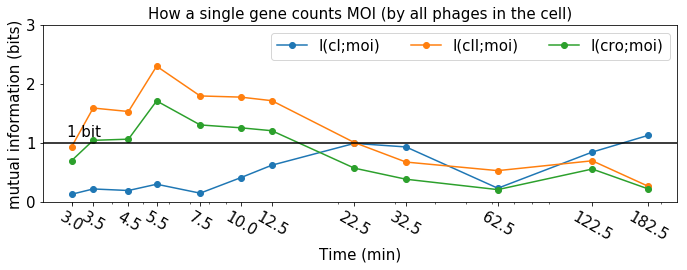

In [51]:
MI_data1 = np.genfromtxt('file4phage_1201/ci.csv',delimiter=',')
MI_data2 = np.genfromtxt('file4phage_1201/cii.csv',delimiter=',')
MI_data3 = np.genfromtxt('file4phage_1201/cro.csv',delimiter=',')
MI_data4 = np.genfromtxt('file4phage_1201/ci_cii.csv',delimiter=',')
MI_data5 = np.genfromtxt('file4phage_1201/ci_cro.csv',delimiter=',')
MI_data6 = np.genfromtxt('file4phage_1201/cii_cro.csv',delimiter=',')
MI_data7 = np.genfromtxt('file4phage_1201/ci_cii_cro.csv',delimiter=',')

fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering5 = np.array(time_after_triggering3)+2.5
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data1,'o-',label='I(cI;moi)') 
plot(time_after_triggering5,MI_data2,'o-',label='I(cII;moi)') 
plot(time_after_triggering5,MI_data3,'o-',label='I(cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
title('How a single gene counts MOI (by all phages in the cell)');legend(ncol=3,loc='upper right')
#axhline(2,color='black');text(2.9,2.1,'2 bit')
axhline(1,color='black'); text(2.9,1.1,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()


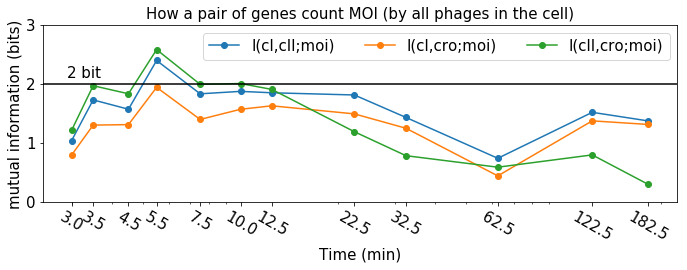

In [50]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering5 = np.array(time_after_triggering3)+2.5
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data4,'o-',label='I(cI,cII;moi)') 
plot(time_after_triggering5,MI_data5,'o-',label='I(cI,cro;moi)') 
plot(time_after_triggering5,MI_data6,'o-',label='I(cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
title('How a pair of genes count MOI (by all phages in the cell)');legend(ncol=3,loc='upper right')
axhline(2,color='black');text(2.9,2.1,'2 bit')
#axhline(1,color='black'); text(10.9,0.7,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

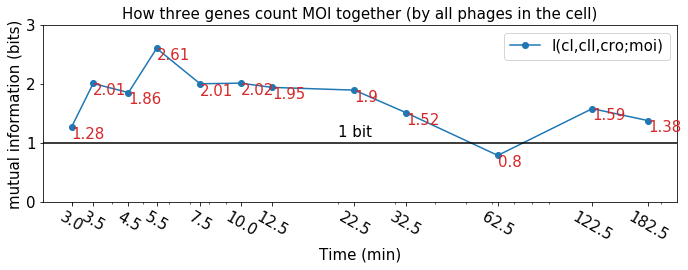

In [45]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data7,'o-',label='I(cI,cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
for i in range(0,len(time_after_triggering5)):
    text(time_after_triggering5[i],MI_data7[i]-0.2,str(round(MI_data7[i],2)),color='tab:red')
title('How three genes count MOI together (by all phages in the cell)');
legend(ncol=3,loc='upper right')
axhline(1,color='black'); text(20,1.1,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

# previous results
## single phage

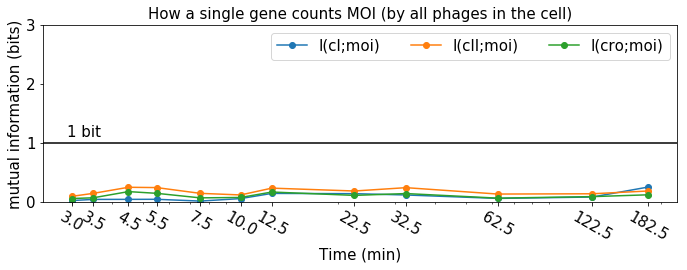

In [55]:
MI_data1 = np.genfromtxt('file2phage_1201/ci.csv',delimiter=',')[:,0]
MI_data2 = np.genfromtxt('file2phage_1201/cii.csv',delimiter=',')[:,0]
MI_data3 = np.genfromtxt('file2phage_1201/cro.csv',delimiter=',')[:,0]
MI_data4 = np.genfromtxt('file2phage_1201/ci_cii.csv',delimiter=',')
MI_data5 = np.genfromtxt('file2phage_1201/ci_cro.csv',delimiter=',')
MI_data6 = np.genfromtxt('file2phage_1201/cii_cro.csv',delimiter=',')
MI_data7 = np.genfromtxt('file2phage_1201/ci_cii_cro.csv',delimiter=',')

fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering5 = np.array(time_after_triggering3)+2.5
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data1,'o-',label='I(cI;moi)') 
plot(time_after_triggering5,MI_data2,'o-',label='I(cII;moi)') 
plot(time_after_triggering5,MI_data3,'o-',label='I(cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
title('How a single gene counts MOI (by all phages in the cell)');legend(ncol=3,loc='upper right')
#axhline(2,color='black');text(2.9,2.1,'2 bit')
axhline(1,color='black'); text(2.9,1.1,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

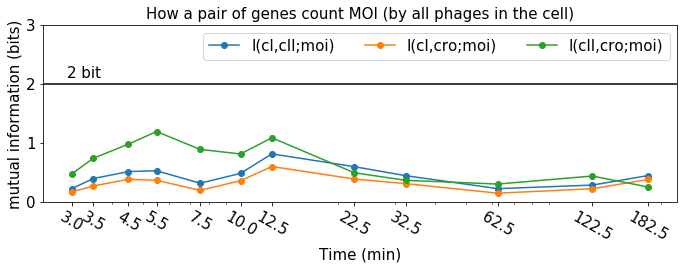

In [56]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering5 = np.array(time_after_triggering3)+2.5
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data4,'o-',label='I(cI,cII;moi)') 
plot(time_after_triggering5,MI_data5,'o-',label='I(cI,cro;moi)') 
plot(time_after_triggering5,MI_data6,'o-',label='I(cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
title('How a pair of genes count MOI (by all phages in the cell)');legend(ncol=3,loc='upper right')
axhline(2,color='black');text(2.9,2.1,'2 bit')
#axhline(1,color='black'); text(10.9,0.7,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

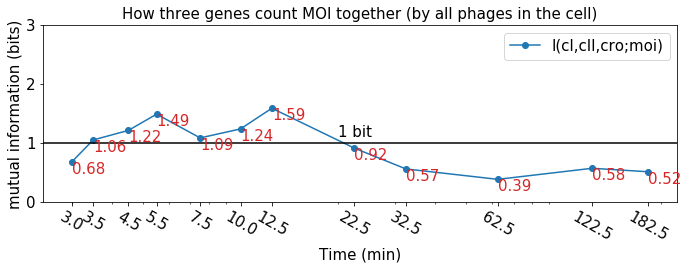

In [57]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data7,'o-',label='I(cI,cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
for i in range(0,len(time_after_triggering5)):
    text(time_after_triggering5[i],MI_data7[i]-0.2,str(round(MI_data7[i],2)),color='tab:red')
title('How three genes count MOI together (by all phages in the cell)');
legend(ncol=3,loc='upper right')
axhline(1,color='black'); text(20,1.1,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

## whole cell

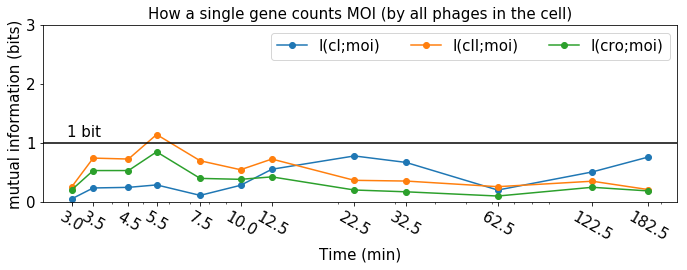

In [58]:
MI_data1 = np.genfromtxt('file2_1201/ci.csv',delimiter=',')[:,0]
MI_data2 = np.genfromtxt('file2_1201/cii.csv',delimiter=',')[:,0]
MI_data3 = np.genfromtxt('file2_1201/cro.csv',delimiter=',')[:,0]
MI_data4 = np.genfromtxt('file2_1201/ci_cii.csv',delimiter=',')
MI_data5 = np.genfromtxt('file2_1201/ci_cro.csv',delimiter=',')
MI_data6 = np.genfromtxt('file2_1201/cii_cro.csv',delimiter=',')
MI_data7 = np.genfromtxt('file2_1201/ci_cii_cro.csv',delimiter=',')

fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering5 = np.array(time_after_triggering3)+2.5
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data1,'o-',label='I(cI;moi)') 
plot(time_after_triggering5,MI_data2,'o-',label='I(cII;moi)') 
plot(time_after_triggering5,MI_data3,'o-',label='I(cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
title('How a single gene counts MOI (by all phages in the cell)');legend(ncol=3,loc='upper right')
#axhline(2,color='black');text(2.9,2.1,'2 bit')
axhline(1,color='black'); text(2.9,1.1,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

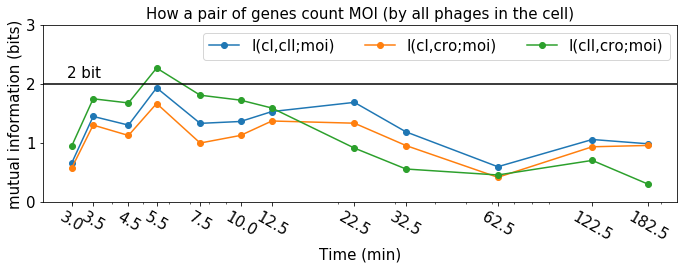

In [59]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering5 = np.array(time_after_triggering3)+2.5
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data4,'o-',label='I(cI,cII;moi)') 
plot(time_after_triggering5,MI_data5,'o-',label='I(cI,cro;moi)') 
plot(time_after_triggering5,MI_data6,'o-',label='I(cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
title('How a pair of genes count MOI (by all phages in the cell)');legend(ncol=3,loc='upper right')
axhline(2,color='black');text(2.9,2.1,'2 bit')
#axhline(1,color='black'); text(10.9,0.7,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()

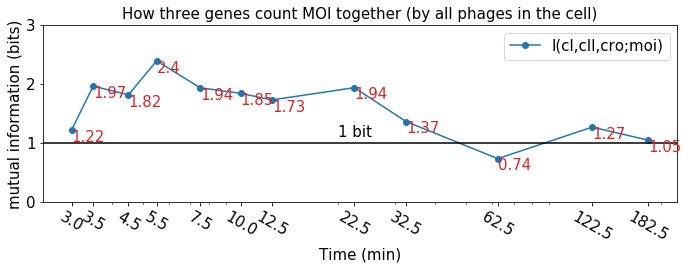

In [60]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering5,MI_data7,'o-',label='I(cI,cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering5,[str(k) for k in time_after_triggering5],rotation=-30)
for i in range(0,len(time_after_triggering5)):
    text(time_after_triggering5[i],MI_data7[i]-0.2,str(round(MI_data7[i],2)),color='tab:red')
title('How three genes count MOI together (by all phages in the cell)');
legend(ncol=3,loc='upper right')
axhline(1,color='black'); text(20,1.1,'1 bit')
ylabel('mutual information (bits)')
ylim(0,3)
tight_layout()